## Determine if resistance score is associated with cell count

Gregory Way, 2020

For every cell line clone and treatment combination, we know two things:

1. Profile resistance score (via singscore)
2. Cell count before and after treatment (must assume uniform seeding density)

In this notebook, I perform a series of systematic visualizations to detect if there is any association between the resistance score and cell count after treatment.
The resistance score was calculated in untreated clones only.
An association between the resistance score and cell count after treatment would provide evidence that we are infact detecting a resistance signature.

### Score interpretation

A high resistance score indicates that the profile has high concordance with samples annotated as resistant to treatment.
A low score indicates that the profile has high concordance with samples annotated as sensitive.
This score is bounded between -1 and 1. 
Therefore, a sample with a high resistance score is hypothesized to be very resistant to the treatment, whereas a sample with a low resistance score is hypothesized to be very sensitive to the treatment.

In [1]:
import pathlib
import numpy as np
import pandas as pd

import plotnine as gg

In [2]:
# Set file names and directories
results_file = pathlib.Path("results/singscore/full_bulk_signature_singscore_results.tsv.gz")
cell_count_dir = pathlib.Path("../0.generate-profiles/cell_counts/")

output_fig_dir = pathlib.Path("figures/cell_count_associations")
output_fig_dir.mkdir(exist_ok=True)

In [3]:
# Load singscore results
scores_df = pd.read_csv(results_file, sep="\t")

# This results file includes model predictions for all three signatures
# Only subset the targeted signature subset
scores_df = scores_df.loc[scores_df.dataset == scores_df.signature, :]
scores_df.Metadata_Plate = scores_df.Metadata_Plate.astype(str)

print(scores_df.shape)
scores_df.head()

(612, 31)


,Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_cell_count,Metadata_clone_number,Metadata_plate_map_name,Metadata_treatment,Metadata_dataset,Metadata_clone_type,Metadata_clone_type_indicator,...,TotalDispersion,UpScore,UpDispersion,DownScore,DownDispersion,Metadata_permuted_p_value,dataset,signature,min_permuted_value,max_permuted_value
0,HCT116bortezomib,B03,2019_02_15_Batch1_20X,16508,WT_parental,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,sensitive,0,...,1859.1804,-0.077089,1355.0964,-0.033984,504.0840,0.799,cloneAE,cloneAE,-0.225942,0.22576
1,HCT116bortezomib,B04,2019_02_15_Batch1_20X,15536,WT_parental,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,sensitive,0,...,1865.8521,-0.125895,1313.5836,-0.015838,552.2685,0.849,cloneAE,cloneAE,-0.225942,0.22576
2,HCT116bortezomib,B05,2019_02_15_Batch1_20X,13969,WT_parental,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,sensitive,0,...,2093.4312,-0.039312,1283.9316,0.040092,809.4996,0.490,cloneAE,cloneAE,-0.225942,0.22576
3,HCT116bortezomib,B06,2019_02_15_Batch1_20X,13101,CloneA,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,resistant,1,...,885.1122,0.236697,406.9737,0.160547,478.1385,0.002,cloneAE,cloneAE,-0.225942,0.22576
4,HCT116bortezomib,B07,2019_02_15_Batch1_20X,13867,CloneA,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,resistant,1,...,690.8916,0.249346,380.2869,0.164915,310.6047,0.001,cloneAE,cloneAE,-0.225942,0.22576


In [4]:
# This is the number of wells in each plate
pd.crosstab(scores_df.Metadata_Plate, scores_df.Metadata_batch)

Metadata_batch,2019_02_15_Batch1_20X,2019_03_20_Batch2,2020_07_02_Batch8,2020_08_24_Batch9,2020_09_08_Batch10
Metadata_Plate,,,,,
207106_exposure320,0,36,0,0,0
218360,0,0,60,0,0
218361,0,0,60,0,0
218696,0,0,0,60,0
218698,0,0,0,60,0
218774,0,0,0,60,0
218852,0,0,0,0,60
218854,0,0,0,0,60
218856,0,0,0,0,60


In [5]:
# Setup a dictionary to load cell count files
plate_info = dict(zip(scores_df.Metadata_Plate, scores_df.Metadata_batch))
plate_info

{'HCT116bortezomib': '2019_02_15_Batch1_20X',
 '207106_exposure320': '2019_03_20_Batch2',
 '218361': '2020_07_02_Batch8',
 '218360': '2020_07_02_Batch8',
 '218698': '2020_08_24_Batch9',
 '218854': '2020_09_08_Batch10',
 '218858': '2020_09_08_Batch10',
 '218774': '2020_08_24_Batch9',
 '218696': '2020_08_24_Batch9',
 '218852': '2020_09_08_Batch10',
 '218856': '2020_09_08_Batch10'}

In [6]:
# Load cell count data
cell_count_data = []
for plate in plate_info:
    batch = plate_info[plate]
    cell_count_file = pathlib.Path(f"{cell_count_dir}/{batch}_{plate}_cell_count.tsv")
    cell_count_df = pd.read_csv(cell_count_file, sep="\t").assign(Metadata_batch=batch)
    cell_count_data.append(cell_count_df)
    
cell_count_data = pd.concat(cell_count_data, sort=True).reset_index(drop=True)
cell_count_data.Metadata_Plate = cell_count_data.Metadata_Plate.astype(str)

print(cell_count_data.shape)
cell_count_data.head()

(612, 17)


,Metadata_CellLine,Metadata_Dosage,Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_cell_density,Metadata_celltype_shorthand_from_plate_graph,Metadata_clone_number,Metadata_date,Metadata_plate_ID,Metadata_plate_filename,Metadata_plate_map_name,Metadata_time_to_adhere,Metadata_treatment,Metadata_treatment_shorthand_from_plate_graph,Metadata_treatment_time,cell_count
0,WT,0.0,HCT116bortezomib,B03,2019_02_15_Batch1_20X,NaN,NaN,NaN,NaN,NaN,NaN,PlateMap_HCT116bortezomib,NaN,NaN,NaN,NaN,16508
1,WT,0.0,HCT116bortezomib,B04,2019_02_15_Batch1_20X,NaN,NaN,NaN,NaN,NaN,NaN,PlateMap_HCT116bortezomib,NaN,NaN,NaN,NaN,15536
2,WT,0.0,HCT116bortezomib,B05,2019_02_15_Batch1_20X,NaN,NaN,NaN,NaN,NaN,NaN,PlateMap_HCT116bortezomib,NaN,NaN,NaN,NaN,13969
3,CloneA,0.0,HCT116bortezomib,B06,2019_02_15_Batch1_20X,NaN,NaN,NaN,NaN,NaN,NaN,PlateMap_HCT116bortezomib,NaN,NaN,NaN,NaN,13101
4,CloneA,0.0,HCT116bortezomib,B07,2019_02_15_Batch1_20X,NaN,NaN,NaN,NaN,NaN,NaN,PlateMap_HCT116bortezomib,NaN,NaN,NaN,NaN,13867


In [7]:
# Merge scores and counts
scores_with_counts_df = scores_df.merge(
    cell_count_data,
    on=["Metadata_Well", "Metadata_batch", "Metadata_Plate", "Metadata_cell_density"],
    suffixes=["", "_count"]
)

# Set factors for plotting downstream
scores_with_counts_df.Metadata_model_split = pd.Categorical(
    scores_with_counts_df.Metadata_model_split,
    categories=["training", "test", "validation", "perturbation"]
)

print(scores_with_counts_df.shape)
scores_with_counts_df.head()

(612, 44)


,Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_cell_count,Metadata_clone_number,Metadata_plate_map_name,Metadata_treatment,Metadata_dataset,Metadata_clone_type,Metadata_clone_type_indicator,...,Metadata_clone_number_count,Metadata_date_count,Metadata_plate_ID_count,Metadata_plate_filename_count,Metadata_plate_map_name_count,Metadata_time_to_adhere_count,Metadata_treatment_count,Metadata_treatment_shorthand_from_plate_graph_count,Metadata_treatment_time_count,cell_count
0,HCT116bortezomib,B03,2019_02_15_Batch1_20X,16508,WT_parental,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,sensitive,0,...,NaN,NaN,NaN,NaN,PlateMap_HCT116bortezomib,NaN,NaN,NaN,NaN,16508
1,HCT116bortezomib,B04,2019_02_15_Batch1_20X,15536,WT_parental,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,sensitive,0,...,NaN,NaN,NaN,NaN,PlateMap_HCT116bortezomib,NaN,NaN,NaN,NaN,15536
2,HCT116bortezomib,B05,2019_02_15_Batch1_20X,13969,WT_parental,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,sensitive,0,...,NaN,NaN,NaN,NaN,PlateMap_HCT116bortezomib,NaN,NaN,NaN,NaN,13969
3,HCT116bortezomib,B06,2019_02_15_Batch1_20X,13101,CloneA,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,resistant,1,...,NaN,NaN,NaN,NaN,PlateMap_HCT116bortezomib,NaN,NaN,NaN,NaN,13101
4,HCT116bortezomib,B07,2019_02_15_Batch1_20X,13867,CloneA,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,resistant,1,...,NaN,NaN,NaN,NaN,PlateMap_HCT116bortezomib,NaN,NaN,NaN,NaN,13867


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6 x 4 in image.
  from_inches(height, units), units))
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/cell_count_associations/cloneAE_untreated_score_by_count.png
  warn('Filename: {}'.format(filename))


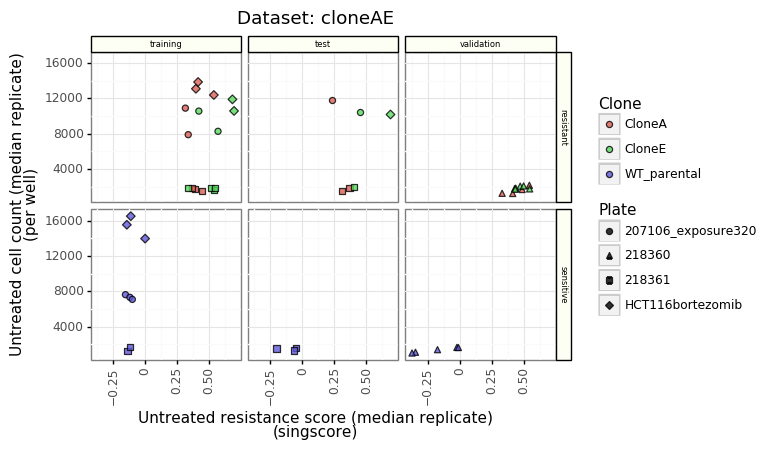

<ggplot: (298945021)>


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6 x 4 in image.
  from_inches(height, units), units))
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/cell_count_associations/ixazomib_untreated_score_by_count.png
  warn('Filename: {}'.format(filename))


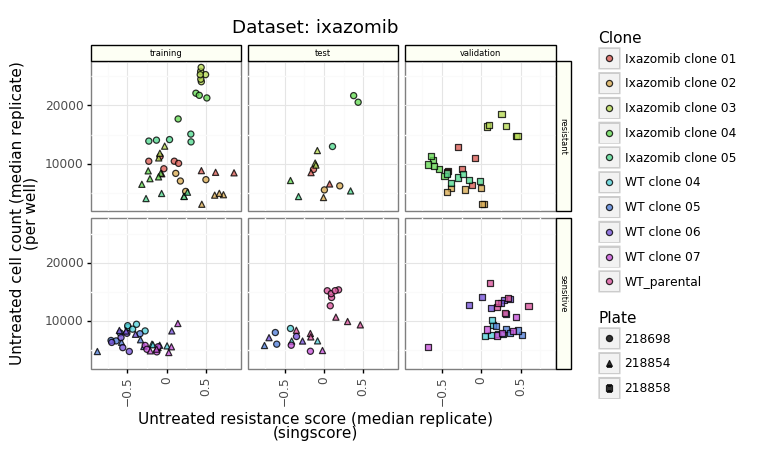

<ggplot: (298334896)>


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6 x 4 in image.
  from_inches(height, units), units))
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/cell_count_associations/cb5083_untreated_score_by_count.png
  warn('Filename: {}'.format(filename))


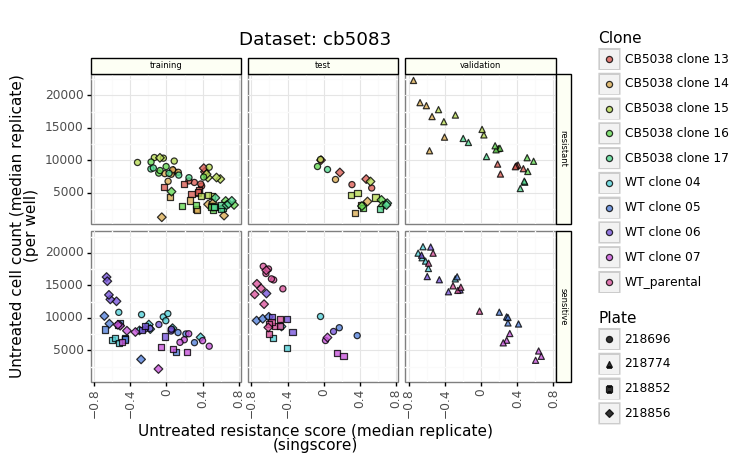

<ggplot: (-9223372036548062944)>


In [8]:
for dataset in scores_with_counts_df.dataset.unique():
    plot_df = (
        scores_with_counts_df
        .query("Metadata_model_split != 'perturbation'")
        .query("dataset == @dataset")
    )
    
    fig_file = pathlib.Path(f"{output_fig_dir}/{dataset}_untreated_score_by_count.png")
    count_score_gg = (
        gg.ggplot(plot_df, gg.aes(y = "cell_count", x = "TotalScore"))
        + gg.geom_point(gg.aes(fill = "Metadata_clone_number", shape="Metadata_Plate"), size=2, alpha=0.8)
        + gg.facet_grid("Metadata_clone_type~Metadata_model_split")
        + gg.theme_bw()
        + gg.scale_fill_discrete(name="Clone")
        + gg.scale_shape_discrete(name="Plate")
        + gg.ylab("Untreated cell count (median replicate)\n(per well)")
        + gg.xlab("Untreated resistance score (median replicate)\n(singscore)")
        + gg.ggtitle(f"Dataset: {dataset}")
        + gg.theme(
            strip_text=gg.element_text(size=6, color="black"),
            strip_background=gg.element_rect(colour="black", fill="#fdfff4"),
            axis_text_x=gg.element_text(rotation=90)
        )
    )
    
    count_score_gg.save(fig_file, width=6, height=4, dpi=500)
    print(count_score_gg)

In [9]:
# Plot several diagnostic plot of cell count by well position
scores_with_counts_df = scores_with_counts_df.assign(
    row=scores_with_counts_df.Metadata_Well.str[0],
    column=scores_with_counts_df.Metadata_Well.str[1:3].astype(int)
)

scores_with_counts_df.row = pd.Categorical(
    scores_with_counts_df.row, categories=(sorted(scores_with_counts_df.row.unique(), reverse=True))
)

scores_with_counts_df.cell_count = scores_with_counts_df.cell_count.astype(float)

plate_layout_plots = []
for dataset in scores_with_counts_df.dataset.unique():
    plot_df = (
        scores_with_counts_df
        .query("Metadata_model_split != 'perturbation'")
        .query("dataset == @dataset")
    )
    for plate in plot_df.Metadata_Plate.unique():

        count_score_gg = (
            gg.ggplot(plot_df.query("Metadata_Plate == @plate"), gg.aes(y="row", x="column"))
                + gg.geom_point(gg.aes(color = "cell_count"), size = 8)
                + gg.facet_grid("Metadata_clone_type~Metadata_model_split")
                + gg.coord_fixed()
                + gg.theme_bw()
                + gg.scale_fill_discrete(name="Clone")
                + gg.ylab("Untreated cell count\n(per well)")
                + gg.xlab("Untreated resistance score\n(singscore)")
                + gg.ggtitle(f"Dataset: {dataset}; Plate: {plate}")
                + gg.theme(
                    strip_text=gg.element_text(size=6, color="black"),
                    strip_background=gg.element_rect(colour="black", fill="#fdfff4")
                )
        )
        
        plate_layout_plots.append(count_score_gg)
        
fig_file = pathlib.Path(f"{output_fig_dir}/plate_layout_summary_full.pdf")
gg.save_as_pdf_pages(plate_layout_plots, filename=fig_file)

/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:826: UserWarning: Filename: figures/cell_count_associations/plate_layout_summary_full.pdf
  warn('Filename: {}'.format(filename))


## Compare untreated score to perturbation cell count drop

For each clone and treatment, we know how many cells are present before and after perturbation.
Does the resistance score correlate with this differential?

We need to average the scores and counts across replicates, since different cells were treated.

## Relative cell count

To quantify cell count changes upon perturbation, we simply take the following ratio:

> Number of Cells after Perturbation / Number of Cells with 0.1% DMSO treatment

A value above 1 indicates that the clone was resistant to treatment.
A value significantly below 1 indicates that the clone was sensitive.

This metric controls for plate seeding density differences, and, since it is an median value, will minimize the within plate across well differences.

## We perform this analysis differently depending on the dataset

The CloneAE data contained treated wells in the same plate as untreated wells.
The Ixazomib and CB-5083 treatments were collected in different plates.

### Step 1: CloneAE Dataset

In [10]:
# Get the median score and cell count per clone and model splits
scores_with_counts_df.Metadata_model_split = scores_with_counts_df.Metadata_model_split.astype(str)

cloneae_summary_df = (
    scores_with_counts_df.query("dataset == 'cloneAE'")
    .groupby(
        [
            "Metadata_batch",
            "Metadata_Plate",
            "Metadata_clone_number",
            "Metadata_treatment",
            "Metadata_model_split",
        ]
    )
    .agg(
        {
            "TotalScore": "median",
            "cell_count": "median"
        }
    )
    .reset_index()
)

# Set factors for plotting downstream
cloneae_summary_df.Metadata_model_split = pd.Categorical(
    cloneae_summary_df.Metadata_model_split,
    categories=["training", "test", "validation", "perturbation"]
)

print(cloneae_summary_df.shape)
cloneae_summary_df.head()

(54, 7)


,Metadata_batch,Metadata_Plate,Metadata_clone_number,Metadata_treatment,Metadata_model_split,TotalScore,cell_count
0,2019_02_15_Batch1_20X,HCT116bortezomib,CloneA,0.1% DMSO,training,0.414261,13101.0
1,2019_02_15_Batch1_20X,HCT116bortezomib,CloneA,2.1 nM bortezomib,perturbation,0.075937,14078.0
2,2019_02_15_Batch1_20X,HCT116bortezomib,CloneA,21 nM bortezomib,perturbation,-0.097020,9399.0
3,2019_02_15_Batch1_20X,HCT116bortezomib,CloneA,210 nM bortezomib,perturbation,-0.214628,8071.0
4,2019_02_15_Batch1_20X,HCT116bortezomib,CloneE,0.1% DMSO,test,0.682025,10276.0


In [11]:
# Merge together treated and untreated cell counts
clonae_perturbation_summary_df = (
    cloneae_summary_df
    .query("Metadata_treatment != '0.1% DMSO'")
    .reset_index(drop=True)
)
clonae_untreated_summary_df = (
    cloneae_summary_df
    .query("Metadata_treatment == '0.1% DMSO'")
    .reset_index(drop=True)
)

cloneae_result = (
    clonae_perturbation_summary_df
    .merge(
        clonae_untreated_summary_df,
        on=["Metadata_Plate", "Metadata_batch", "Metadata_clone_number"],
        how="left",
        suffixes=["_perturbed", "_untreated"]
    )
)

# Generate a simple relative cell count metric
cloneae_result = cloneae_result.assign(
    relative_cell_count=cloneae_result.cell_count_perturbed / cloneae_result.cell_count_untreated
)

print(cloneae_result.shape)
cloneae_result.head()

(54, 12)


,Metadata_batch,Metadata_Plate,Metadata_clone_number,Metadata_treatment_perturbed,Metadata_model_split_perturbed,TotalScore_perturbed,cell_count_perturbed,Metadata_treatment_untreated,Metadata_model_split_untreated,TotalScore_untreated,cell_count_untreated,relative_cell_count
0,2019_02_15_Batch1_20X,HCT116bortezomib,CloneA,2.1 nM bortezomib,perturbation,0.075937,14078.0,0.1% DMSO,training,0.414261,13101.0,1.074574
1,2019_02_15_Batch1_20X,HCT116bortezomib,CloneA,21 nM bortezomib,perturbation,-0.097020,9399.0,0.1% DMSO,training,0.414261,13101.0,0.717426
2,2019_02_15_Batch1_20X,HCT116bortezomib,CloneA,210 nM bortezomib,perturbation,-0.214628,8071.0,0.1% DMSO,training,0.414261,13101.0,0.616060
3,2019_02_15_Batch1_20X,HCT116bortezomib,CloneE,2.1 nM bortezomib,perturbation,0.681897,11173.0,0.1% DMSO,test,0.682025,10276.0,1.087291
4,2019_02_15_Batch1_20X,HCT116bortezomib,CloneE,2.1 nM bortezomib,perturbation,0.681897,11173.0,0.1% DMSO,training,0.688509,11246.0,0.993509


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 5 x 4 in image.
  from_inches(height, units), units))
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/cell_count_associations/cloneAE_treatment_score_by_count.png
  warn('Filename: {}'.format(filename))


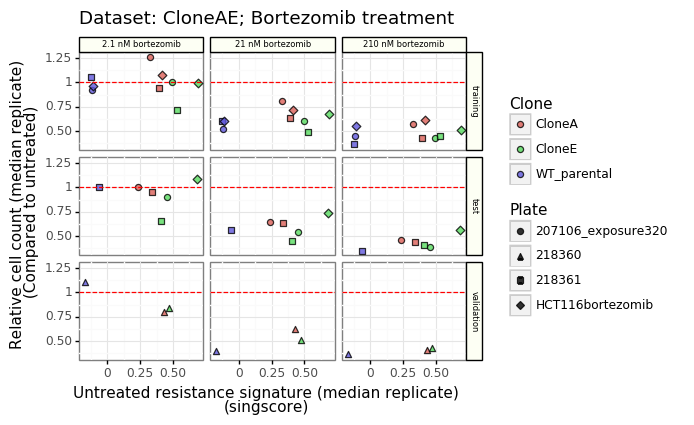

<ggplot: (306691869)>

In [12]:
cloneAE_score_count_gg = (
    gg.ggplot(cloneae_result, gg.aes(x="TotalScore_untreated", y="relative_cell_count"))
    + gg.geom_point(gg.aes(fill="Metadata_clone_number", shape="Metadata_Plate"), size=2, alpha=0.8)
    + gg.xlab("Untreated resistance signature (median replicate)\n(singscore)")
    + gg.ylab("Relative cell count (median replicate)\n (Compared to untreated)")
    + gg.ggtitle("Dataset: CloneAE; Bortezomib treatment")
    + gg.geom_hline(yintercept=1, linetype="dashed", color="red")
    + gg.scale_fill_discrete(name="Clone")
    + gg.scale_shape_discrete(name="Plate")
    + gg.facet_grid("Metadata_model_split_untreated~Metadata_treatment_perturbed")
    + gg.theme_bw()
    + gg.theme(
        strip_text=gg.element_text(size=6, color="black"),
        strip_background=gg.element_rect(colour="black", fill="#fdfff4")
    )
)

fig_file = pathlib.Path(f"{output_fig_dir}/cloneAE_treatment_score_by_count.png")
cloneAE_score_count_gg.save(fig_file, width=5, height=4, dpi=500)

cloneAE_score_count_gg

### Step 2: Ixazomib and CB-5083

Both of these cell lines were acquired with a different plate layout than the cloneAE dataset.
Specifically, each plate were subject to indepedent treatments: DMSO and each drug treatment were collected on separate plates.

To compare cell counts before and after treatment, we must assume similar seeding density (this is a relatively safe assumption, since this info was captured) and compare treated plates to DMSO plates.
To protect against seeding density artifacts, we compare the median cell count with the median resistance signature.

In [13]:
# Load treatment plates
treatment_plate_info = {
    '218775': "2020_08_24_Batch9",
    '218699': '2020_08_24_Batch9',
    '218697': '2020_08_24_Batch9',
    '218853': '2020_09_08_Batch10',
    '218855': '2020_09_08_Batch10',
    '218857': '2020_09_08_Batch10',
    '218859': '2020_09_08_Batch10',
}

treatment_cell_count_data = []
for plate in treatment_plate_info:
    batch = treatment_plate_info[plate]
    cell_count_file = pathlib.Path(f"{cell_count_dir}/{batch}_{plate}_cell_count.tsv")
    cell_count_df = pd.read_csv(cell_count_file, sep="\t").assign(Metadata_batch=batch)
    treatment_cell_count_data.append(cell_count_df)
    
treatment_cell_count_data = pd.concat(treatment_cell_count_data, sort=True).reset_index(drop=True)
treatment_cell_count_data.Metadata_Plate = treatment_cell_count_data.Metadata_Plate.astype(str)

treatment_cell_count_summary_df = (
    treatment_cell_count_data.groupby(
        ["Metadata_batch", "Metadata_treatment", "Metadata_clone_number", "Metadata_cell_density"]
    ).agg(
        {
            "cell_count": "median"
        }
    )
    .reset_index()
    .assign(dataset="cb5083")
)

treatment_cell_count_summary_df.loc[
        treatment_cell_count_summary_df.Metadata_treatment.str.contains("Ixazomib"), "dataset"
] = "ixazomib"


print(treatment_cell_count_summary_df.shape)
treatment_cell_count_summary_df.head()

(70, 6)


,Metadata_batch,Metadata_treatment,Metadata_clone_number,Metadata_cell_density,cell_count,dataset
0,2020_08_24_Batch9,50 nM Ixazomib,Ixazomib clone 01,5x10^3 cells/well,8263.0,ixazomib
1,2020_08_24_Batch9,50 nM Ixazomib,Ixazomib clone 02,5x10^3 cells/well,7046.0,ixazomib
2,2020_08_24_Batch9,50 nM Ixazomib,Ixazomib clone 03,5x10^3 cells/well,21305.5,ixazomib
3,2020_08_24_Batch9,50 nM Ixazomib,Ixazomib clone 04,5x10^3 cells/well,21048.5,ixazomib
4,2020_08_24_Batch9,50 nM Ixazomib,Ixazomib clone 05,5x10^3 cells/well,10904.0,ixazomib


In [14]:
# Calculate median resistance scores and merge with perturbation cell counts
other_treatment_summary_df = (
    scores_with_counts_df.query("dataset != 'cloneAE'")
    .groupby(
        [
            "Metadata_batch",
            "Metadata_Plate",
            "Metadata_clone_number",
            "Metadata_clone_type",
            "Metadata_treatment",
            "Metadata_model_split",
            "Metadata_cell_density",
            "dataset"
        ]
    )
    .agg(
        {
            "TotalScore": "median",
            "cell_count": "median"
        }
    )
    .reset_index()
)


other_treatment_summary_df = other_treatment_summary_df.merge(
    treatment_cell_count_summary_df,
    on=["Metadata_batch", "Metadata_clone_number", "Metadata_cell_density", "dataset"],
    suffixes=["_untreated", "_perturbed"]
)

other_treatment_summary_df = other_treatment_summary_df.assign(
    relative_cell_count=(
        other_treatment_summary_df.cell_count_perturbed / other_treatment_summary_df.cell_count_untreated
    )
)

other_treatment_summary_df.Metadata_model_split = pd.Categorical(
    other_treatment_summary_df.Metadata_model_split,
    categories=["training", "test", "validation"]
)

print(other_treatment_summary_df.shape)
other_treatment_summary_df.head()

(105, 13)


,Metadata_batch,Metadata_Plate,Metadata_clone_number,Metadata_clone_type,Metadata_treatment_untreated,Metadata_model_split,Metadata_cell_density,dataset,TotalScore,cell_count_untreated,Metadata_treatment_perturbed,cell_count_perturbed,relative_cell_count
0,2020_08_24_Batch9,218696,CB5038 clone 13,resistant,0.1% DMSO,test,5x10^3 cells/well,cb5083,0.420637,6000.5,700 nM CB-5083,5041.5,0.840180
1,2020_08_24_Batch9,218696,CB5038 clone 13,resistant,0.1% DMSO,training,5x10^3 cells/well,cb5083,0.344034,6474.0,700 nM CB-5083,5041.5,0.778730
2,2020_08_24_Batch9,218696,CB5038 clone 14,resistant,0.1% DMSO,test,5x10^3 cells/well,cb5083,0.118697,7171.0,700 nM CB-5083,7323.0,1.021196
3,2020_08_24_Batch9,218696,CB5038 clone 14,resistant,0.1% DMSO,training,5x10^3 cells/well,cb5083,0.053335,7952.0,700 nM CB-5083,7323.0,0.920900
4,2020_08_24_Batch9,218696,CB5038 clone 15,resistant,0.1% DMSO,test,5x10^3 cells/well,cb5083,-0.043059,10126.0,700 nM CB-5083,6713.0,0.662947


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 5 x 4 in image.
  from_inches(height, units), units))
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/cell_count_associations/cb5083_treatment_score_by_count.png
  warn('Filename: {}'.format(filename))


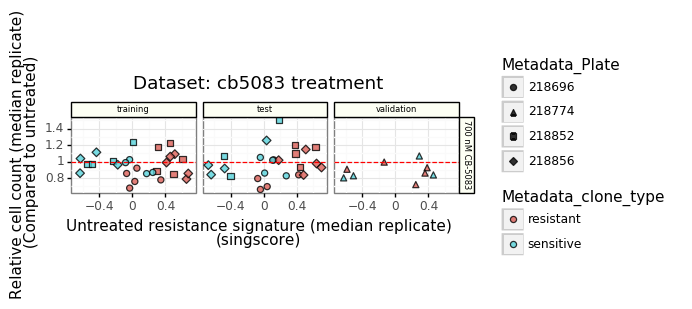

<ggplot: (298771597)>


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 5 x 4 in image.
  from_inches(height, units), units))
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/cell_count_associations/ixazomib_treatment_score_by_count.png
  warn('Filename: {}'.format(filename))


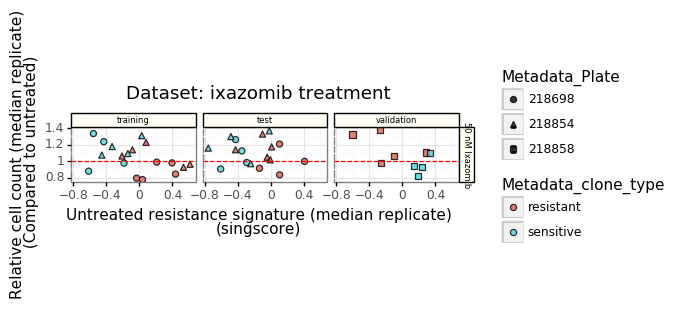

<ggplot: (301062471)>


In [15]:
for dataset in other_treatment_summary_df.dataset.unique():

    score_count_gg = (
        gg.ggplot(other_treatment_summary_df.query("dataset == @dataset"),
                  gg.aes(x="TotalScore", y="relative_cell_count"))
        + gg.geom_point(gg.aes(fill="Metadata_clone_type", shape="Metadata_Plate"), size=2, alpha=0.8)
        + gg.coord_fixed()
        + gg.xlab("Untreated resistance signature (median replicate)\n(singscore)")
        + gg.ylab("Relative cell count (median replicate)\n (Compared to untreated)")
        + gg.ggtitle(f"Dataset: {dataset} treatment")
        + gg.geom_hline(yintercept=1, linetype="dashed", color="red")
        + gg.facet_grid("Metadata_treatment_perturbed~Metadata_model_split")
        + gg.theme_bw()
        + gg.theme(
            strip_text=gg.element_text(size=6, color="black"),
            strip_background=gg.element_rect(colour="black", fill="#fdfff4")
        )
    )
    
    fig_file = pathlib.Path(f"{output_fig_dir}/{dataset}_treatment_score_by_count.png")
    score_count_gg.save(fig_file, width=5, height=4, dpi=500)

    print(score_count_gg)